# Building the EchoScope Model - 2

In [5]:
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.tensorboard import SummaryWriter

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
writer = SummaryWriter(log_dir="runs/spectrogram_exp_1")

In [8]:
IQ_Processed = np.load('../data/processed_iq_data.npz')
Spectrogram_Processed = np.load('../data/spectrograms.npz')

In [9]:
X_list = []
y_list = []

for key_str in IQ_Processed.files:
    key = ast.literal_eval(key_str)
    mod_name = key[0]
    data = IQ_Processed[key_str]
    
    X_list.append(data)
    y_list.extend([mod_name] * data.shape[0])

X = np.vstack(X_list)
y = np.array(y_list)

print(f'Total samples: {X.shape[0]}')
print(f'Unique modulations: {np.unique(y)}')
unique_modulations = np.unique(y)

Total samples: 220000
Unique modulations: ['8PSK' 'AM-DSB' 'AM-SSB' 'BPSK' 'CPFSK' 'GFSK' 'PAM4' 'QAM16' 'QAM64'
 'QPSK' 'WBFM']


In [10]:
def split_sets(X, y):
    X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)
    
    print(f'Train shape: {X_train.shape}, {y_train.shape}')
    print(f'Validation shape: {X_val.shape}, {y_val.shape}')
    print(f'Test shape: {X_test.shape}, {y_test.shape}')
    return X_train, y_train, X_val, y_val, X_test, y_test

In [11]:
X_train, y_train, X_val, y_val, X_test, y_test = split_sets(X, y)

Train shape: (132000, 2, 128), (132000,)
Validation shape: (44000, 2, 128), (44000,)
Test shape: (44000, 2, 128), (44000,)


In [12]:
LE = LabelEncoder()
y_train_enc = LE.fit_transform(y_train)
y_val_enc = LE.transform(y_val)
y_test_enc = LE.transform(y_test)

print(LE.classes_)

['8PSK' 'AM-DSB' 'AM-SSB' 'BPSK' 'CPFSK' 'GFSK' 'PAM4' 'QAM16' 'QAM64'
 'QPSK' 'WBFM']


In [13]:
train_dataset_time = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train_enc, dtype=torch.long))
val_dataset_time = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val_enc, dtype=torch.long))
test_dataset_time = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test_enc, dtype=torch.long))

train_loader_time = DataLoader(train_dataset_time, batch_size=64, shuffle=True)
val_loader_time = DataLoader(val_dataset_time, batch_size=64, shuffle=False)
test_loader_time = DataLoader(test_dataset_time, batch_size=64, shuffle=False)

In [14]:
class Time_Series_Model(nn.Module):
    def __init__(self, input_size=128, hidden_size=32, output_size=11, num_layers=1, dropout=0.5):
        super(Time_Series_Model, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=False,
            dropout=0.0  
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_out = lstm_out[:, -1, :]
        out = self.dropout(last_out)
        out = self.fc(out)
        return out

In [15]:
Time_Series_Model_V1 = Time_Series_Model()
Time_Series_Model_V1 = Time_Series_Model_V1.to(device)

In [16]:
def set_seed(seed=1):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

In [17]:
import copy

def train_model(model, criterion, optimizer, epochs, train_loader, val_loader, patience=5, scheduler=None):
    best_val_loss = float('inf')
    best_model_state = None
    no_improve_epochs = 0
    
    train_losses = []
    val_losses = []

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * X_batch.size(0)
        val_loss /= len(val_loader.dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")
        writer.add_scalar("Loss/Train", train_loss, epoch)
        writer.add_scalar("Loss/Val", val_loss, epoch)
        writer.add_scalar("LR", optimizer.param_groups[0]['lr'], epoch)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print(f"Early stopping at epoch {epoch} (best val loss: {best_val_loss:.6f})")
                break
        if scheduler:
            scheduler.step(val_loss)
            
    model.load_state_dict(best_model_state)
    return train_losses, val_losses


In [37]:
optimizer = optim.Adam(Time_Series_Model_V1.parameters(), lr=0.0001)
train_losses, val_losses = train_model(model=Time_Series_Model_V1, criterion=nn.CrossEntropyLoss(), 
            optimizer=optimizer, epochs=50, train_loader=train_loader_time, 
            val_loader=val_loader_time)

Epoch 1/50 | Train Loss: 2.388333 | Val Loss: 2.354848
Epoch 2/50 | Train Loss: 2.327306 | Val Loss: 2.280576
Epoch 3/50 | Train Loss: 2.255591 | Val Loss: 2.201292
Epoch 4/50 | Train Loss: 2.193607 | Val Loss: 2.143463
Epoch 5/50 | Train Loss: 2.150877 | Val Loss: 2.106070
Epoch 6/50 | Train Loss: 2.122958 | Val Loss: 2.081842
Epoch 7/50 | Train Loss: 2.106184 | Val Loss: 2.066046
Epoch 8/50 | Train Loss: 2.093800 | Val Loss: 2.055415
Epoch 9/50 | Train Loss: 2.082397 | Val Loss: 2.047184
Epoch 10/50 | Train Loss: 2.075003 | Val Loss: 2.041186
Epoch 11/50 | Train Loss: 2.068880 | Val Loss: 2.036187
Epoch 12/50 | Train Loss: 2.063343 | Val Loss: 2.031884
Epoch 13/50 | Train Loss: 2.056228 | Val Loss: 2.028146
Epoch 14/50 | Train Loss: 2.051057 | Val Loss: 2.024981
Epoch 15/50 | Train Loss: 2.045896 | Val Loss: 2.022233
Epoch 16/50 | Train Loss: 2.042582 | Val Loss: 2.019870
Epoch 17/50 | Train Loss: 2.038370 | Val Loss: 2.017261
Epoch 18/50 | Train Loss: 2.034570 | Val Loss: 2.015283
E

### Hyperparameter Trials: 

#### Trial 1: Complex model w/o dropout
The model overfitted with the following hyperparameters: input_size=128, hidden_size=64, output_size=11, num_layers=1, dropout=0, learning_rate=0.0001, optimizer=Adam, loss_fn=CrossEntropyLoss, epochs=50, using a bidirectional LSTM without effective dropout due to num_layers=1.

#### Trial 2: Complex model w/ dropout
The model previously overfitted using the following configuration: input_size=128, hidden_size=64, output_size=11, num_layers=2, dropout=0.5, bidirectional=True, learning_rate=0.0001, optimizer=Adam, and CrossEntropyLoss. Despite enabling both internal and external dropout, validation loss steadily increased while training loss decreased, indicating the model capacity was too high for the dataset. This prompted a simplification of the architecture to reduce overfitting risk.

#### Trial 3: Simplified model w/dropout
The simplified model (input_size=128, hidden_size=32, output_size=11, num_layers=1, dropout=0.5, bidirectional=False, learning_rate=0.0001) showed significantly improved generalization compared to the previous overfitted configuration. Both training and validation loss decreased steadily over 50 epochs, confirming that reducing model complexity effectively mitigated overfitting and led to stable convergence.

In [18]:
epochs = range(1, 51)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'train_losses' is not defined

<Figure size 1000x600 with 0 Axes>

In [19]:
keys = Spectrogram_Processed.files
print(keys)

key_example = "('QPSK', 2)"
if key_example in keys:
    data = Spectrogram_Processed[key_example]
    print(f"Data shape for {key_example}:", data.shape)
else:
    print(f"{key_example} not found in the file.")

["('QPSK', 2)", "('PAM4', 8)", "('AM-DSB', -4)", "('GFSK', 6)", "('QAM64', 8)", "('AM-SSB', 12)", "('8PSK', 8)", "('8PSK', 12)", "('QAM64', -6)", "('QAM16', 2)", "('QAM16', -20)", "('PAM4', -6)", "('WBFM', -18)", "('AM-DSB', 16)", "('CPFSK', 10)", "('WBFM', 6)", "('BPSK', 4)", "('BPSK', -2)", "('QPSK', -20)", "('CPFSK', -8)", "('AM-SSB', 6)", "('QAM64', -20)", "('QAM16', 12)", "('GFSK', -20)", "('AM-SSB', -12)", "('CPFSK', 0)", "('AM-DSB', 6)", "('BPSK', -16)", "('QPSK', -6)", "('8PSK', -12)", "('CPFSK', -18)", "('BPSK', -10)", "('QPSK', 8)", "('PAM4', 14)", "('AM-DSB', -10)", "('GFSK', 12)", "('QAM64', 2)", "('WBFM', -4)", "('AM-SSB', -18)", "('QAM64', -4)", "('GFSK', -4)", "('AM-DSB', 8)", "('PAM4', -16)", "('QPSK', -16)", "('BPSK', 16)", "('8PSK', -8)", "('CPFSK', 16)", "('WBFM', 0)", "('QPSK', 6)", "('BPSK', 14)", "('AM-DSB', -8)", "('GFSK', -10)", "('CPFSK', -2)", "('AM-SSB', 8)", "('GFSK', 18)", "('QAM16', 6)", "('QAM16', -16)", "('QAM64', 18)", "('AM-SSB', -2)", "('CPFSK', 6)", 

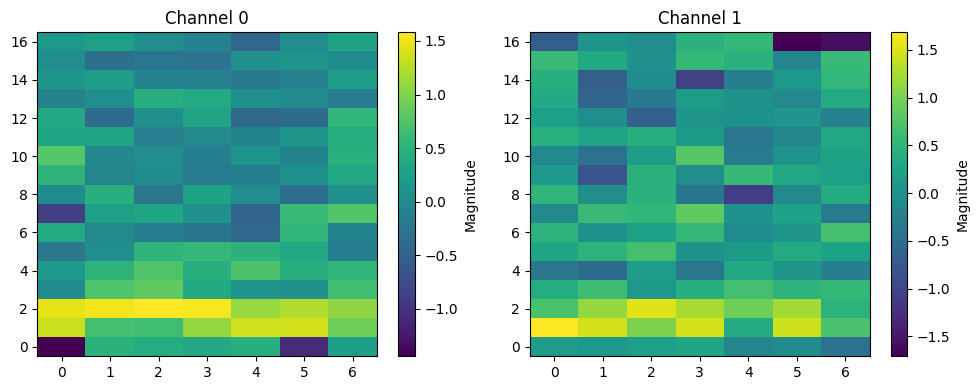

In [20]:
example = data[0] 
plt.figure(figsize=(10,4))
for ch in range(example.shape[0]):
    plt.subplot(1, 2, ch+1)
    plt.title(f'Channel {ch}')
    plt.imshow(example[ch], aspect='auto', origin='lower')
    plt.colorbar(label='Magnitude')
plt.tight_layout()
plt.show()

In [21]:
all_data_spect = []
all_labels_spect = []
keys_tuples = [eval(k) if isinstance(k, str) else k for k in Spectrogram_Processed.keys()]
label_map = {mod: i for i, mod in enumerate(unique_modulations)}

for key in keys_tuples:
    modulation = key[0]
    str_key = str(key)
    data = Spectrogram_Processed[str_key]
    all_data_spect.append(data)
    
    labels = np.full(data.shape[0], label_map[modulation])
    all_labels_spect.append(labels)

X = np.concatenate(all_data_spect, axis=0)
y = np.concatenate(all_labels_spect, axis=0)

print(f"Combined data shape: {X.shape}")
print(f"Combined labels shape: {y.shape}")
print(f"Label map: {label_map}")


Combined data shape: (220000, 2, 17, 7)
Combined labels shape: (220000,)
Label map: {np.str_('8PSK'): 0, np.str_('AM-DSB'): 1, np.str_('AM-SSB'): 2, np.str_('BPSK'): 3, np.str_('CPFSK'): 4, np.str_('GFSK'): 5, np.str_('PAM4'): 6, np.str_('QAM16'): 7, np.str_('QAM64'): 8, np.str_('QPSK'): 9, np.str_('WBFM'): 10}


In [22]:
X_train, y_train, X_val, y_val, X_test, y_test = split_sets(X, y)

Train shape: (132000, 2, 17, 7), (132000,)
Validation shape: (44000, 2, 17, 7), (44000,)
Test shape: (44000, 2, 17, 7), (44000,)


In [23]:
LE = LabelEncoder()
y_train_enc = LE.fit_transform(y_train)
y_val_enc = LE.transform(y_val)
y_test_enc = LE.transform(y_test)

print(LE.classes_)

[ 0  1  2  3  4  5  6  7  8  9 10]


In [24]:
train_dataset_spect = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train_enc, dtype=torch.long))
val_dataset_spect = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val_enc, dtype=torch.long))
test_dataset_spect = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test_enc, dtype=torch.long))

train_loader_spect = DataLoader(train_dataset_spect, batch_size=64, shuffle=True)
val_loader_spect = DataLoader(val_dataset_spect, batch_size=64, shuffle=False)
test_loader_spect = DataLoader(test_dataset_spect, batch_size=64, shuffle=False)

In [25]:
class SpectrogramPatchEncoder(nn.Module):
    def __init__(self, in_channels=2, patch_size=(1, 1), embed_dim=128, img_size=(33, 3)):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim

        self.num_patches = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])

        self.proj = nn.Conv2d(
            in_channels,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )
        
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches + 1, embed_dim))

    def forward(self, x):
        B = x.size(0)
        x = self.proj(x) 
        x = x.flatten(2).transpose(1, 2)

        cls_tokens = self.cls_token.expand(B, -1, -1)

        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed

        return x

In [31]:
class SpectrogramModel(nn.Module):
    def __init__(self, in_channels=2, img_size=(17, 7), patch_size=(1, 2), embed_dim=256, num_classes=11):
        super().__init__()
        self.patch_encoder = SpectrogramPatchEncoder(
            in_channels=in_channels,
            patch_size=patch_size,
            embed_dim=embed_dim,
            img_size=img_size
        )
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=8, dim_feedforward=256, batch_first=True),
            num_layers=4
        )
        self.classifier = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Dropout(0.3),
            nn.Linear(embed_dim, num_classes)
        )
    def forward(self, x):
        x = self.patch_encoder(x)
        x = self.transformer(x)
        x = x[:, 0]
        x = self.classifier(x)
        return x
        

In [27]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced", 
    classes=np.unique(y_train_enc), 
    y=y_train_enc
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.1)

In [28]:
Spectrogram_Model_V1 = SpectrogramModel(in_channels=2, img_size=(17, 7), patch_size=(1, 2), embed_dim=256,
                                                 num_classes=11).to(device)

In [29]:
optimizer = optim.Adam(Spectrogram_Model_V1.parameters(), lr=0.0001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
train_losses_spect, val_losses_spect = train_model(model=Spectrogram_Model_V1, criterion=criterion, 
            optimizer=optimizer, epochs=50, train_loader=train_loader_spect, 
            val_loader=val_loader_spect, scheduler=scheduler)

Epoch 1/50 | Train Loss: 1.983348 | Val Loss: 1.879537
Epoch 2/50 | Train Loss: 1.867766 | Val Loss: 1.826203
Epoch 3/50 | Train Loss: 1.821454 | Val Loss: 1.784803
Epoch 4/50 | Train Loss: 1.803473 | Val Loss: 1.778803
Epoch 5/50 | Train Loss: 1.790519 | Val Loss: 1.773808
Epoch 6/50 | Train Loss: 1.782914 | Val Loss: 1.795271
Epoch 7/50 | Train Loss: 1.774918 | Val Loss: 1.766638
Epoch 8/50 | Train Loss: 1.768608 | Val Loss: 1.765053
Epoch 9/50 | Train Loss: 1.763728 | Val Loss: 1.761574
Epoch 10/50 | Train Loss: 1.760512 | Val Loss: 1.771174
Epoch 11/50 | Train Loss: 1.756386 | Val Loss: 1.754052
Epoch 12/50 | Train Loss: 1.754613 | Val Loss: 1.772113
Epoch 13/50 | Train Loss: 1.751407 | Val Loss: 1.740493
Epoch 14/50 | Train Loss: 1.749622 | Val Loss: 1.750428
Epoch 15/50 | Train Loss: 1.747830 | Val Loss: 1.750025
Epoch 16/50 | Train Loss: 1.745374 | Val Loss: 1.732953
Epoch 17/50 | Train Loss: 1.742462 | Val Loss: 1.761796
Epoch 18/50 | Train Loss: 1.740021 | Val Loss: 1.732473
E

In [30]:
Spectrogram_Model_V1.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader_spect:
        X_batch = X_batch.to(device)
        outputs = Spectrogram_Model_V1(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(y_batch.numpy())

print(classification_report(y_true, y_pred, target_names=[str(c) for c in LE.classes_]))

              precision    recall  f1-score   support

           0       0.27      0.31      0.29      4000
           1       0.56      0.63      0.59      4000
           2       0.24      0.97      0.38      4000
           3       0.58      0.54      0.56      4000
           4       0.69      0.57      0.62      4000
           5       0.83      0.57      0.68      4000
           6       0.83      0.38      0.52      4000
           7       0.28      0.04      0.06      4000
           8       0.45      0.43      0.44      4000
           9       0.35      0.17      0.23      4000
          10       0.79      0.17      0.28      4000

    accuracy                           0.43     44000
   macro avg       0.53      0.43      0.42     44000
weighted avg       0.53      0.43      0.42     44000



The spectrogram transformer model was trained with patch_size=(3, 3), embed_dim=128, 4 transformer layers, and 8 attention heads using the Adam optimizer (lr=1e-4) over a maximum of 50 epochs with early stopping (patience=5).
The best validation loss achieved was 1.6093, occurring at Epoch 12, after which performance plateaued and slightly degraded, indicating early signs of overfitting. This model achieved an accuracy of 39%. 

With in_channels=2, patch size (1, 1), and an embedding dimension of 256, the Spectrogram Transformer model trained over 50 epochs achieved a plateau in validation loss around epoch 20, indicating the need for architectural or regularization improvements to further enhance generalization.

We trained a multi-class classification model on spectrogram data using a patch-based encoder with early stopping. Using current hyperparameters, the model achieved a validation loss of 1.5028, with a final test accuracy of 43%, and best per-class F1-scores in the range of 0.66–0.72 for 4 out of 11 classes, indicating strong performance on some signal types but difficulties with others (notably classes 1, 2, 7, and 10).

Spectrograms were standardized using global channel-wise mean and standard deviation. The model employed a patch encoder with a patch size of (1, 2) and an embedding dimension of 256. A 4-layer Transformer with 8 attention heads and a feedforward dimension of 256 was used for feature extraction. Classification was performed using a LayerNorm, dropout of 0.3, and a final linear layer outputting 11 classes. Training used CrossEntropyLoss with label smoothing (0.1) and class weights to handle imbalance, optimized with Adam (learning rate 1e-4, weight decay 1e-4), and a ReduceLROnPlateau scheduler. After 25 epochs, the model achieved 50% test accuracy, outperforming the previous best by 7%, even without Gaussian noise or other augmentations.

The model trained for 38 epochs with Gaussian noise augmentation (mean 0, std 0.05) on spectrogram inputs achieved about 49% accuracy, a slight drop from the baseline 50% without noise. Despite this, key classes maintained strong recall, notably class 2 at 95%, and mid-performing classes (3–6) kept solid F1 scores between 0.65 and 0.72. Importantly, recall for difficult classes like 7 improved from 7% to 15%, showing increased robustness. This indicates that adding Gaussian noise helps the model generalize better, particularly on challenging classes, and with longer training or additional augmentations, further gains are likely.